In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from glob import glob
import yaml

In [2]:
with open("../config.yaml", "r") as file:
    config = yaml.safe_load(file)

In [3]:
labels = glob("../label/*.json")
labels.sort()

In [4]:
# Read the json file
with open(labels[-1],"r") as f:
    data = json.load(f)
    print(f)

<_io.TextIOWrapper name='../label/project-5-at-2024-07-14-17-52-c7bec176.json' mode='r' encoding='UTF-8'>


In [5]:
entities = []
relations = []
sent_entities = []
sent_relations = []

for sentence in data:
    t_entities = []
    t_relations = []
    for annotation in sentence["annotations"][0]["result"]:
        if annotation["type"] == "labels":
            entities.append(annotation["value"]["labels"][0])
            t_entities.append(annotation["value"]["labels"][0])
        elif annotation["type"] == "relation":
            relations.append(annotation["labels"])
    sent_entities.append(list(set(t_entities)))
 #   sent_relations.append(list(set(relations)))

In [6]:
sentences = [sentence["data"]["text"] for sentence in data]

check duplicated sentences. True means no duplicates

In [7]:
len(set(sentences)) == len(sentences)

True

In [8]:
len(set(sentences))

3832

In [9]:
from collections import Counter

# Count the occurrences of each sentence
sentence_counts = Counter(sentences)

# Find the duplicate sentences
duplicate_sentences = [sentence for sentence, count in sentence_counts.items() if count > 1]

print(duplicate_sentences)

[]


In [10]:
relations = [item for items in relations for item in items]
#entities = [item for items in entities for item in items]
sent_entities = [item for items in sent_entities for item in items]

In [11]:
pd.DataFrame(sent_entities).value_counts()

STRAIN       2494
COMPOUND     1410
ORGANISM     1162
EFFECT        960
PROTEIN       787
SPECIES       738
PHENOTYPE     550
ISOLATE       516
MEDIUM        360
DISEASE       328
GENE          301
GENUS         178
VIRUS         114
ASSEMBLY        6
Name: count, dtype: int64

In [12]:
ner_df = pd.DataFrame(sent_entities).value_counts().reset_index().rename(columns={0:"ner", "count":"count_per_sentence"})

Text(0.5, 1.0, 'Number of sentences with entity')

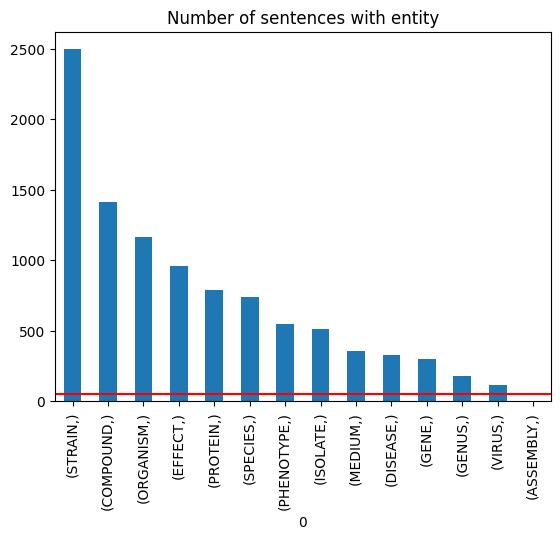

In [13]:
pd.DataFrame(sent_entities).value_counts().plot(kind='bar')
plt.axhline(50, color='red')
plt.title('Number of sentences with entity')

In [14]:
ner_df = ner_df.merge(pd.DataFrame(entities).value_counts().reset_index().rename(columns={0:"ner", "count":"count_per_entity"}))


Text(0.5, 1.0, 'Total number of entities')

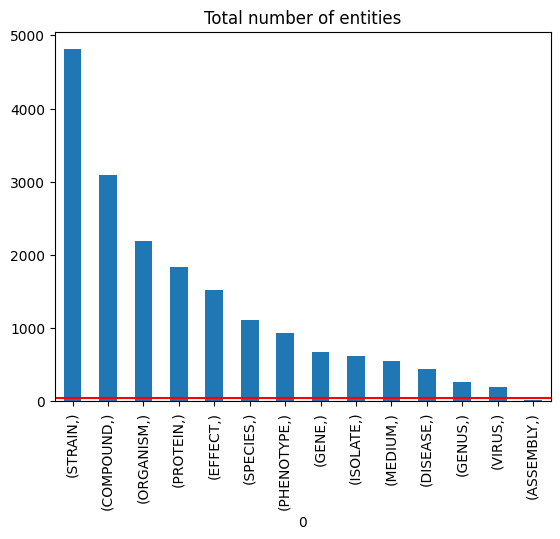

In [15]:
pd.DataFrame(entities).value_counts().plot(kind='bar')
plt.axhline(50, color='red')
plt.title('Total number of entities')

In [16]:
ner_df_m = ner_df.melt("ner", var_name="type", value_name="count")

In [17]:
ner_df_m

,ner,type,count
0,STRAIN,count_per_sentence,2494
1,COMPOUND,count_per_sentence,1410
2,ORGANISM,count_per_sentence,1162
3,EFFECT,count_per_sentence,960
4,PROTEIN,count_per_sentence,787
5,SPECIES,count_per_sentence,738
6,PHENOTYPE,count_per_sentence,550
7,ISOLATE,count_per_sentence,516
8,MEDIUM,count_per_sentence,360
9,DISEASE,count_per_sentence,328


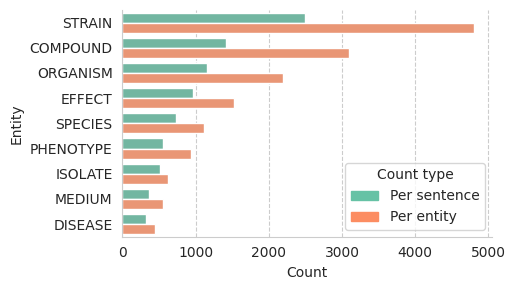

In [18]:
import matplotlib.patches as mpatches

# Define the colors for the legend
colors = ["#66c2a5", "#fc8d62"]

# Create the patches for the legend
patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, ["Per sentence", "Per entity"])]

# Set the style to show faint vertical grid lines
sns.set_style("whitegrid", {"axes.grid": True, "grid.linestyle": "--", "grid.alpha": 0.3})

# Plot the graph
sns.catplot(y="ner", x="count", hue="type", kind="bar", data=ner_df_m[ner_df_m["ner"].isin(config["ner_labels"])], palette="Set2", legend=False, height=3, aspect=1.75)
plt.xlabel("Count")
plt.ylabel("Entity")
plt.legend(handles=patches, title="Count type")

plt.savefig("./figures/predictions/labeled_entities_counts.pdf")

### Correlate sizes with performance

In [24]:
metrics_ner = pd.read_csv("../NER_output/aggregated_eval.tsv",sep="\t",index_col=0)

In [28]:
ner_df_m_filter = ner_df_m[ner_df_m["ner"].isin(config["ner_labels"])].set_index("ner")

In [32]:
metrics_merged = ner_df_m_filter.merge(metrics_ner,left_index=True,right_index=True)

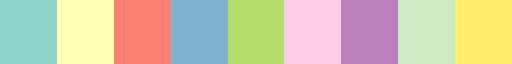

In [42]:
plt.get_cmap('Set3',9)

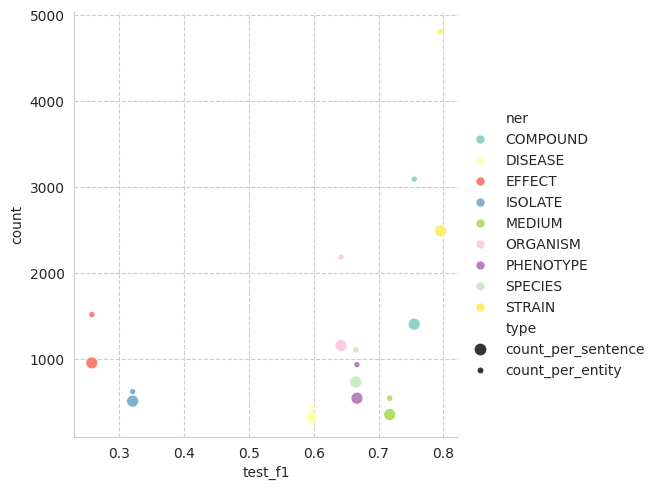

In [48]:
cmap = plt.get_cmap('Set3',9)
palette = [cmap(i) for i in range(cmap.N)]
sns.relplot(data =metrics_merged.reset_index(), x = "test_f1", y = "count", hue="ner", 
            size= "type",palette=palette)
plt.savefig("./figures/predictions/labeled_entities_to_performance.pdf")

### RELS

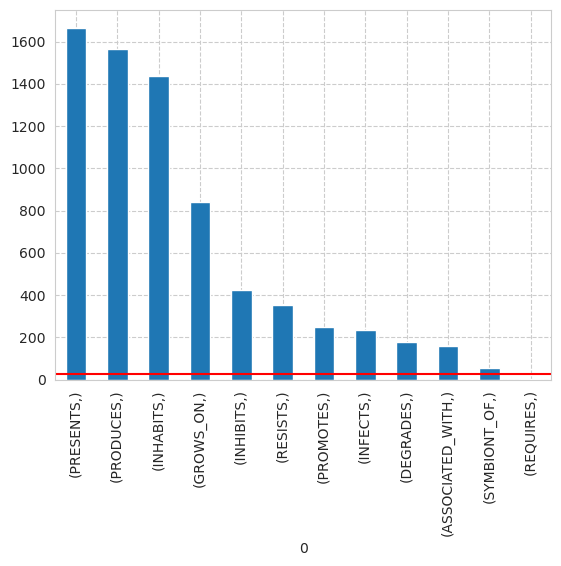

In [19]:
pd.DataFrame(relations).value_counts().plot(kind='bar')
plt.axhline(25, color='red')

In [20]:
sentence_id = []
sentence_text = []
relationships = []
for sentence in data:
    ids = {} # id -> label dictionary
    for annotation in sentence["annotations"][0]["result"]:
        if annotation["type"] == "labels":
            ids[annotation["id"]] = annotation["value"]["labels"]
#            text[annotation["id"]] = annotation["value"]["text"]
        elif annotation["type"] == "relation":
            for label in annotation["labels"]:
#            print(ids.get(annotation["from_id"]),"->", ids.get(annotation["to_id"]), ":", annotation["labels"])
                s = str(*ids.get(annotation["from_id"]))+"->"+ str(*ids.get(annotation["to_id"]))+ ":"+ str(label)
                relationships.append(s)
                sentence_text.append(sentence["data"]["text"])
                sentence_id.append(sentence["id"])

In [21]:
df = pd.DataFrame({"sentence_id":sentence_id, "text" : sentence_text,"relationship":relationships})

In [22]:
grouped = df.groupby(["sentence_id", "relationship"]).count().reset_index()
filtered = grouped[grouped["relationship"] == "STRAIN->ORGANISM:SYMBIONT_OF"]

Make split using `pd.sample`

In [23]:
counts = pd.DataFrame(relationships).value_counts()

In [24]:
df[df["relationship"]=="COMPOUND->STRAIN:INHIBITS"].text.unique()

array(['RTK17.1 batch experiments, is further evidence of organic acid-induced cytosolic acidification and is consistent with reports that formic acid does not support growth in M. infernorum V4 ( Dunfield et al., 2007 ), and inhibits growth in Methylacidiphilum fumariolicum SolV at acidic pH values ( Pol et al., 2007 ).',
       'The serial passage of B. vietnamiensis strain G4 on TSA with a gradual increase in HEPB concentrations (to above the MIC) was repeated until growth ceased.',
       'Mitomycin C MIC of AYE, AB0057, A424, KR3831, and ATCC 17978 was found to range from 32-64 µg/mL.',
       'Similarly, the absence of the c us S gene (Cu sensor) in the P. glacincola BNF20 genome could be responsible for its copper sensitivity, in spite the presence of other genes that participate in Cu homeostasis ( Rensing & Grass, 2003 ).',
       'Among the efflux genes, the expression of adeB and adeC were highest with five- to sevenfold in DR2 and AB067 strains compared with DR1, a carbapen

In [25]:
cnts = counts.reset_index()

In [26]:
cnts[(cnts[0].str.contains("STRAIN"))&(cnts["count"]>0)].set_index(0)

,count
0,
STRAIN->PHENOTYPE:PRESENTS,980
STRAIN->ISOLATE:INHABITS,904
STRAIN->COMPOUND:PRODUCES,836
STRAIN->MEDIUM:GROWS_ON,759
STRAIN->PROTEIN:PRODUCES,490
STRAIN->ORGANISM:INHABITS,452
STRAIN->EFFECT:PRESENTS,350
STRAIN->COMPOUND:RESISTS,305
STRAIN->ORGANISM:INFECTS,182


Text(0, 0.5, '')

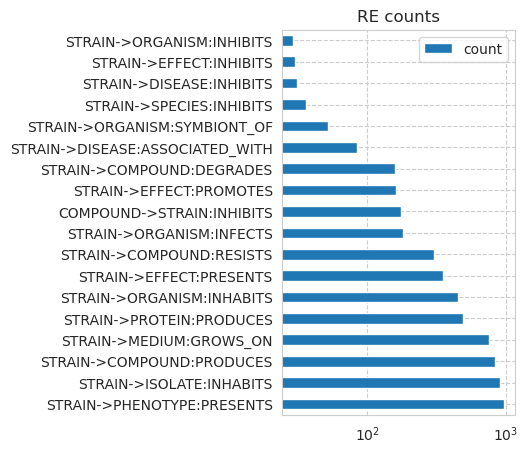

In [27]:
cnts[(cnts[0].str.contains("STRAIN"))&(cnts["count"]>12)].set_index(0).plot(kind='barh',figsize=(3,5),logx=True)
plt.title("RE counts")
plt.ylabel("")

In [28]:
c = cnts.rename(columns={0:"relationship"})

In [29]:
c["re"] = c.relationship.str.split(":",expand=True)[1]
c["ner_re"] = c.relationship.str.split(":",expand=True)[0]

In [30]:
c["non_strain_ner"] = c.relationship.str.split(":", expand=True)[0].str.split("->").apply(lambda x: [elem for elem in x if elem != "STRAIN"])


In [31]:
c["relationship"] = c.relationship.str.replace("->", "-")
c["ner_re"] = c["ner_re"].str.replace("->", "-")

In [32]:
cs = c[c['non_strain_ner'].apply(lambda x: len(x) == 1)]


In [33]:
cs.set_index("re")[["ner_re", "count"]]

,ner_re,count
re,,
PRESENTS,STRAIN-PHENOTYPE,980
INHABITS,STRAIN-ISOLATE,904
PRODUCES,STRAIN-COMPOUND,836
GROWS_ON,STRAIN-MEDIUM,759
PRODUCES,STRAIN-PROTEIN,490
INHABITS,STRAIN-ORGANISM,452
PRESENTS,STRAIN-EFFECT,350
RESISTS,STRAIN-COMPOUND,305
INFECTS,STRAIN-ORGANISM,182


In [34]:
cs['non_strain_ner'] = cs['non_strain_ner'].explode()


/scratch/ipykernel_98315/975501423.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cs['non_strain_ner'] = cs['non_strain_ner'].explode()


In [35]:
cs_filter = cs[(cs["count"]>11)&(cs["non_strain_ner"]!="VIRUS")&(cs["non_strain_ner"]!="PROTEIN")]

In [36]:
cs_filter

,relationship,count,re,ner_re,non_strain_ner
0,STRAIN-PHENOTYPE:PRESENTS,980,PRESENTS,STRAIN-PHENOTYPE,PHENOTYPE
1,STRAIN-ISOLATE:INHABITS,904,INHABITS,STRAIN-ISOLATE,ISOLATE
2,STRAIN-COMPOUND:PRODUCES,836,PRODUCES,STRAIN-COMPOUND,COMPOUND
3,STRAIN-MEDIUM:GROWS_ON,759,GROWS_ON,STRAIN-MEDIUM,MEDIUM
5,STRAIN-ORGANISM:INHABITS,452,INHABITS,STRAIN-ORGANISM,ORGANISM
6,STRAIN-EFFECT:PRESENTS,350,PRESENTS,STRAIN-EFFECT,EFFECT
7,STRAIN-COMPOUND:RESISTS,305,RESISTS,STRAIN-COMPOUND,COMPOUND
8,STRAIN-ORGANISM:INFECTS,182,INFECTS,STRAIN-ORGANISM,ORGANISM
9,COMPOUND-STRAIN:INHIBITS,175,INHIBITS,COMPOUND-STRAIN,COMPOUND
10,STRAIN-EFFECT:PROMOTES,161,PROMOTES,STRAIN-EFFECT,EFFECT


In [37]:
pivot_df = cs_filter.pivot_table(index='re', columns='non_strain_ner', values='count', aggfunc='sum').fillna(0)


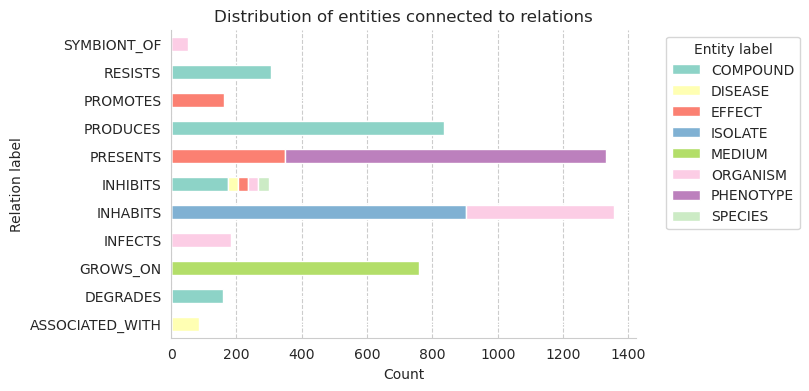

In [38]:
# Get the colormap
cmap = plt.get_cmap('Set3',9)
colors = [cmap(i) for i in range(len(pivot_df.columns))]

# Create a color dictionary to map each column to a color
color_dict = {column: colors[i] for i, column in enumerate(pivot_df.columns)}

ax = pivot_df.plot(kind='barh', stacked=True, color=[color_dict[col] for col in pivot_df.columns], figsize=(6, 4))

plt.xlabel('Count')
plt.ylabel('Relation label')
plt.title('Distribution of entities connected to relations')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Entity label")

# Remove horizontal axis lines in the background
plt.grid(axis='y', which='both', color='white')

# Remove the right spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.savefig("./figures/predictions/relationship_distribution.pdf", bbox_inches='tight')